In [45]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.metrics import mean_squared_error, max_error
from xgboost import XGBRegressor

In [46]:
harmony_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\Harmony_data.csv')
IHS_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\IHS_data.csv')
train_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\production_data_train.csv', parse_dates=[['Month', 'Year']])

harmony_data.shape, IHS_data.shape, train_data.shape

((8930, 7), (9224, 14), (394074, 9))

In [47]:
train_data.rename(columns={'Month_Year':'Date'}, inplace=True)

In [48]:
train_data.set_index('Date', inplace=True)

In [49]:
IHS = IHS_data.drop_duplicates(subset=['API'])

In [50]:
for column in IHS.columns:
    train_data[column] = train_data['API'].map(dict(zip(IHS.API, IHS[column])))

for column in harmony_data.columns:
    train_data[column] = train_data['API'].map(dict(zip(harmony_data.API, harmony_data[column])))


In [51]:
df = train_data.drop(['_LastUpdate', 'PermitDate', 'SpudDate', 'CompletionDate','FirstProductionDate'], axis=1)

In [52]:
df['API'] = df.API.astype(str)

In [53]:
for label, content in df.items():
    if content.dtype == 'object':
        df[label] = pd.Categorical(content).codes

In [54]:
df_date = pd.DataFrame(columns=df.columns)
for well in df.API.unique():
    order = df[(df['API'] == well)].sort_values(by='Date')
    df_date = pd.concat([df_date, order], axis=0)

In [55]:
df_date['Liquid'] = df_date.Liquid.astype(int)

In [56]:
df_date.index.name = 'Date'

In [57]:
df_date['API+I'] = df_date.index.astype(str) + df_date.API.astype(str)

In [58]:
df_date = df_date.dropna()

In [59]:
df_date = df_date.drop_duplicates(subset=['API+I'])

In [60]:
for well in df_date.API.unique():
    df_date[(df_date.API == well)] = df_date[(df_date.API == well) & (df_date.index >= df_date[(df_date.API == well)].Liquid.idxmax())]

df_date.dropna(inplace=True)

In [61]:
df_date.drop(['API+I'], axis=1, inplace=True)

In [62]:
def trans_num(df):
    for label, content in df_date.items():
        if content.dtype == 'object':
            df[label] = content.astype(int)

In [63]:
trans_num(df_date)

In [64]:
import warnings
warnings.filterwarnings("ignore")

df_pro_ord = pd.DataFrame()

for well in df_date.API.unique():
    df_test = df_date[df_date.API == well]
    df_test['Month_Ord'] = np.arange(len(df_test))

    df_pro_ord = pd.concat((df_pro_ord, df_test), axis=0)

<AxesSubplot:>

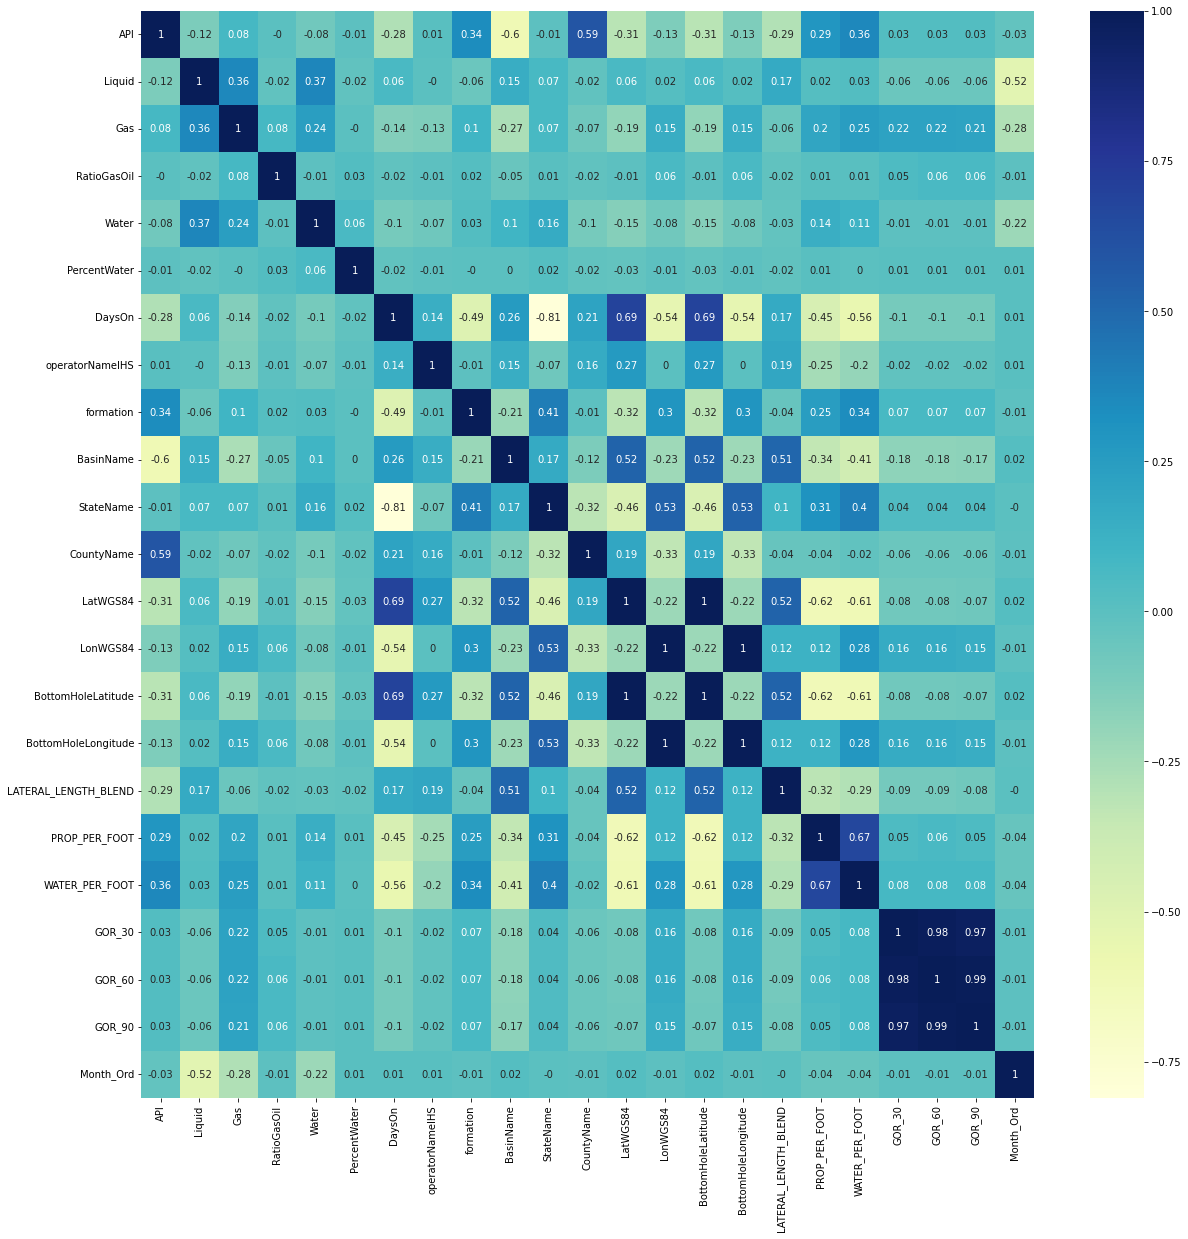

In [65]:
fig, ax = plt.subplots(figsize = (20,20))
sns.heatmap(round(df_pro_ord.corr(),2), annot=True, cmap='YlGnBu');

In [66]:
df_peak = df_pro_ord.drop(['Gas', 'RatioGasOil', 'Water', 'PercentWater','DaysOn', 'operatorNameIHS',  'StateName', 
'CountyName', 'LatWGS84', 'LonWGS84', 'BottomHoleLatitude','BottomHoleLongitude', 'PROP_PER_FOOT','WATER_PER_FOOT', 'GOR_30', 'GOR_60', 'GOR_90'], axis=1)

In [67]:
train_batch = np.random.choice(df_peak.API.unique(),round(len(df_peak.API.unique())*0.8), replace=False)
df_peak_train = df_peak[df_peak.API.isin(train_batch)]
df_peak_valid = df_peak[~df_peak.API.isin(train_batch)]

In [68]:
X_train, Y_train = df_peak_train.drop('Liquid',axis=1), df_peak_train.Liquid
X_valid, Y_valid = df_peak_valid.drop('Liquid',axis=1), df_peak_valid.Liquid

In [69]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.01, early_stopping_rounds=100).fit(X_train, Y_train, eval_set=[(X_train, Y_train),(X_valid, Y_valid)], verbose=50)

[0]	validation_0-rmse:4808.95560	validation_1-rmse:4726.30526
[50]	validation_0-rmse:3537.44528	validation_1-rmse:3448.13875
[100]	validation_0-rmse:2910.68319	validation_1-rmse:2825.55110
[150]	validation_0-rmse:2617.00470	validation_1-rmse:2544.55638
[200]	validation_0-rmse:2479.29084	validation_1-rmse:2423.71861
[250]	validation_0-rmse:2408.86823	validation_1-rmse:2370.61379
[300]	validation_0-rmse:2367.93457	validation_1-rmse:2345.98506
[350]	validation_0-rmse:2340.30338	validation_1-rmse:2334.30129
[400]	validation_0-rmse:2319.22486	validation_1-rmse:2327.36658
[450]	validation_0-rmse:2300.87788	validation_1-rmse:2320.63800
[500]	validation_0-rmse:2284.18532	validation_1-rmse:2315.09666
[550]	validation_0-rmse:2266.98972	validation_1-rmse:2310.03855
[600]	validation_0-rmse:2250.59722	validation_1-rmse:2305.14599
[650]	validation_0-rmse:2238.59951	validation_1-rmse:2301.62784
[700]	validation_0-rmse:2228.24134	validation_1-rmse:2298.50396
[750]	validation_0-rmse:2218.89871	validati

In [70]:
df_peak_valid['Liquid_pred'] = xgb_reg.predict(X_valid)

Well Number:2755


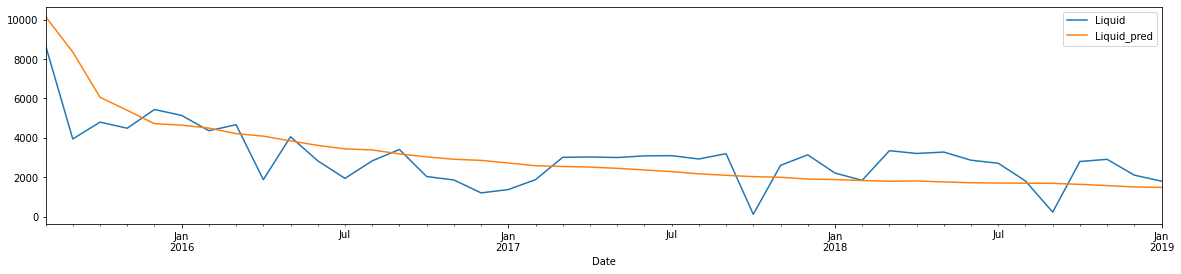

In [71]:
well = np.random.choice(df_peak_valid.API.unique(),1)[0]
df_peak_valid[df_peak_valid.API == well].Liquid.plot(figsize=(20,4))
df_peak_valid[df_peak_valid.API == well].Liquid_pred.plot()
print(f'Well Number:{well}')
plt.legend()
plt.show()

In [72]:
df_peak.to_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\API Oil Production\Datasets\Oil_prod_curve.csv')